**Created by Sanskar Hasija**

**😡😱😊😐😔 Emotion Detection**

**28 OCTOBER 2021**


# <center> 😡😱😊😐😔 EMOTION DETECTION </center>
## <center>If you find this notebook useful, support with an upvote👍</center>

## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet169 Model](#model)  ##
## [5. Training and Fine Tuning](#train) ##
## [6. Visualizing Results](#vis) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
!pip install pandas numpy==1.26.4 matplotlib seaborn plotly tensorflow==2.10 scikit-learn ipython opencv-python # nbformat==4.2.0

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf

# Check if TensorFlow detects a GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using a GPU.")
else:
    print("No GPU detected. TensorFlow is using the CPU.")

TensorFlow is using a GPU.


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [4]:
import os

# Get the current working directory (where your script is running)
current_dir = os.getcwd()

train_dir = os.path.join(current_dir, "train")
test_dir = os.path.join(current_dir, "test")

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 5
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness']
CLASS_LABELS_EMOJIS = ["👿", "😱" , "😊" , "😐 ", "😔"]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [5]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 20082 images belonging to 5 classes.
Found 5020 images belonging to 5 classes.
Found 6236 images belonging to 5 classes.


## Images with different emotions

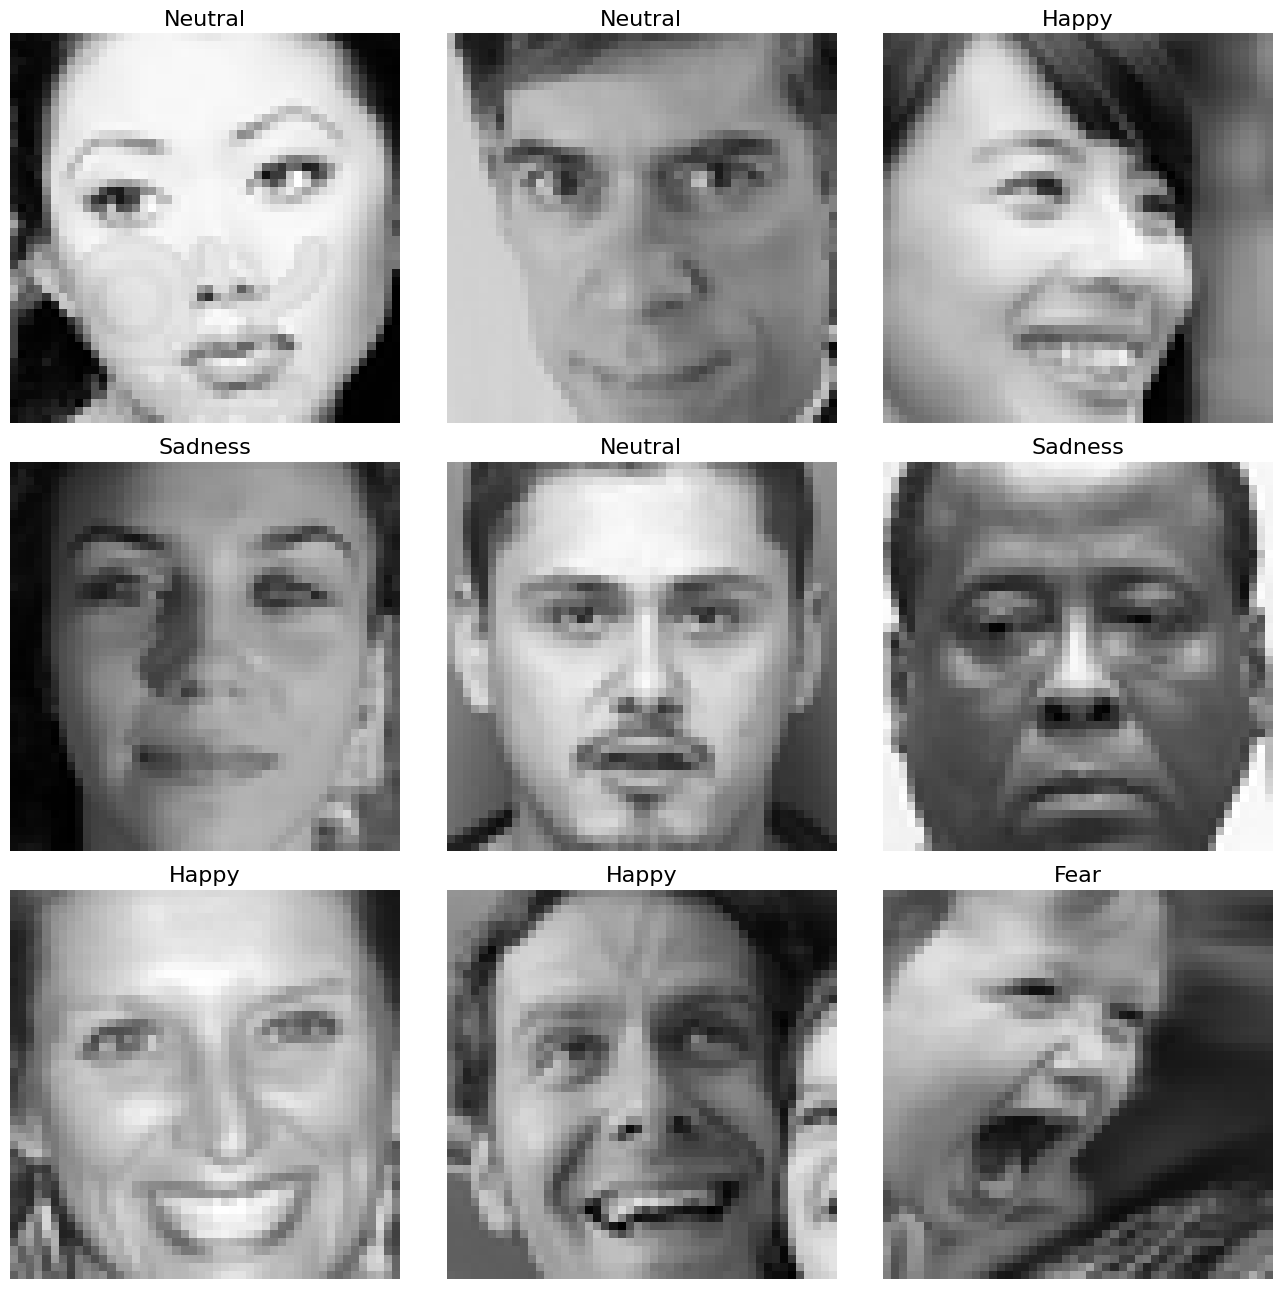

In [6]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [7]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [8]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [ ]:
model = define_compile_model()
clear_output()
# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [10]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
314/314 [==============================] - 34s 69ms/step - loss: 10.3813 - accuracy: 0.2833 - val_loss: 5.9636 - val_accuracy: 0.2875
Epoch 2/30
314/314 [==============================] - 19s 60ms/step - loss: 4.0272 - accuracy: 0.3131 - val_loss: 2.8847 - val_accuracy: 0.2249
Epoch 3/30
314/314 [==============================] - 19s 61ms/step - loss: 2.1079 - accuracy: 0.3848 - val_loss: 1.7666 - val_accuracy: 0.4056
Epoch 4/30
314/314 [==============================] - 18s 57ms/step - loss: 1.5193 - accuracy: 0.4259 - val_loss: 1.3988 - val_accuracy: 0.4462
Epoch 5/30
314/314 [==============================] - 18s 58ms/step - loss: 1.3334 - accuracy: 0.4487 - val_loss: 1.3353 - val_accuracy: 0.4518
Epoch 6/30
314/314 [==============================] - 19s 60ms/step - loss: 1.2575 - accuracy: 0.4651 - val_loss: 1.2186 - val_accuracy: 0.5056
Epoch 7/30
314/314 [==============================] - 20s 64ms/step - loss: 1.2122 - accuracy: 0.4903 - val_loss: 1.1974 - val_accuracy

## Fine Tuning

In [11]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history), ignore_index=True)
#history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)


Epoch 1/20
314/314 [==============================] - 29s 65ms/step - loss: 0.9496 - accuracy: 0.6536 - val_loss: 0.9898 - val_accuracy: 0.6400
Epoch 2/20
314/314 [==============================] - 19s 59ms/step - loss: 0.9171 - accuracy: 0.6699 - val_loss: 0.9798 - val_accuracy: 0.6460
Epoch 3/20
314/314 [==============================] - 18s 57ms/step - loss: 0.9065 - accuracy: 0.6721 - val_loss: 0.9753 - val_accuracy: 0.6504
Epoch 4/20
314/314 [==============================] - 19s 59ms/step - loss: 0.8987 - accuracy: 0.6737 - val_loss: 0.9707 - val_accuracy: 0.6506
Epoch 5/20
314/314 [==============================] - 19s 61ms/step - loss: 0.8939 - accuracy: 0.6779 - val_loss: 0.9683 - val_accuracy: 0.6520
Epoch 6/20
314/314 [==============================] - 19s 60ms/step - loss: 0.8843 - accuracy: 0.6835 - val_loss: 0.9668 - val_accuracy: 0.6534
Epoch 7/20
314/314 [==============================] - 19s 61ms/step - loss: 0.8755 - accuracy: 0.6876 - val_loss: 0.9644 - val_accuracy:

AttributeError: 'DataFrame' object has no attribute 'append'

In [13]:
model.save('emotion_predictor.h5')

## Training plots

In [14]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [15]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [16]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

98/98 [==============================] - 3s 20ms/step


## Confusion Matrix

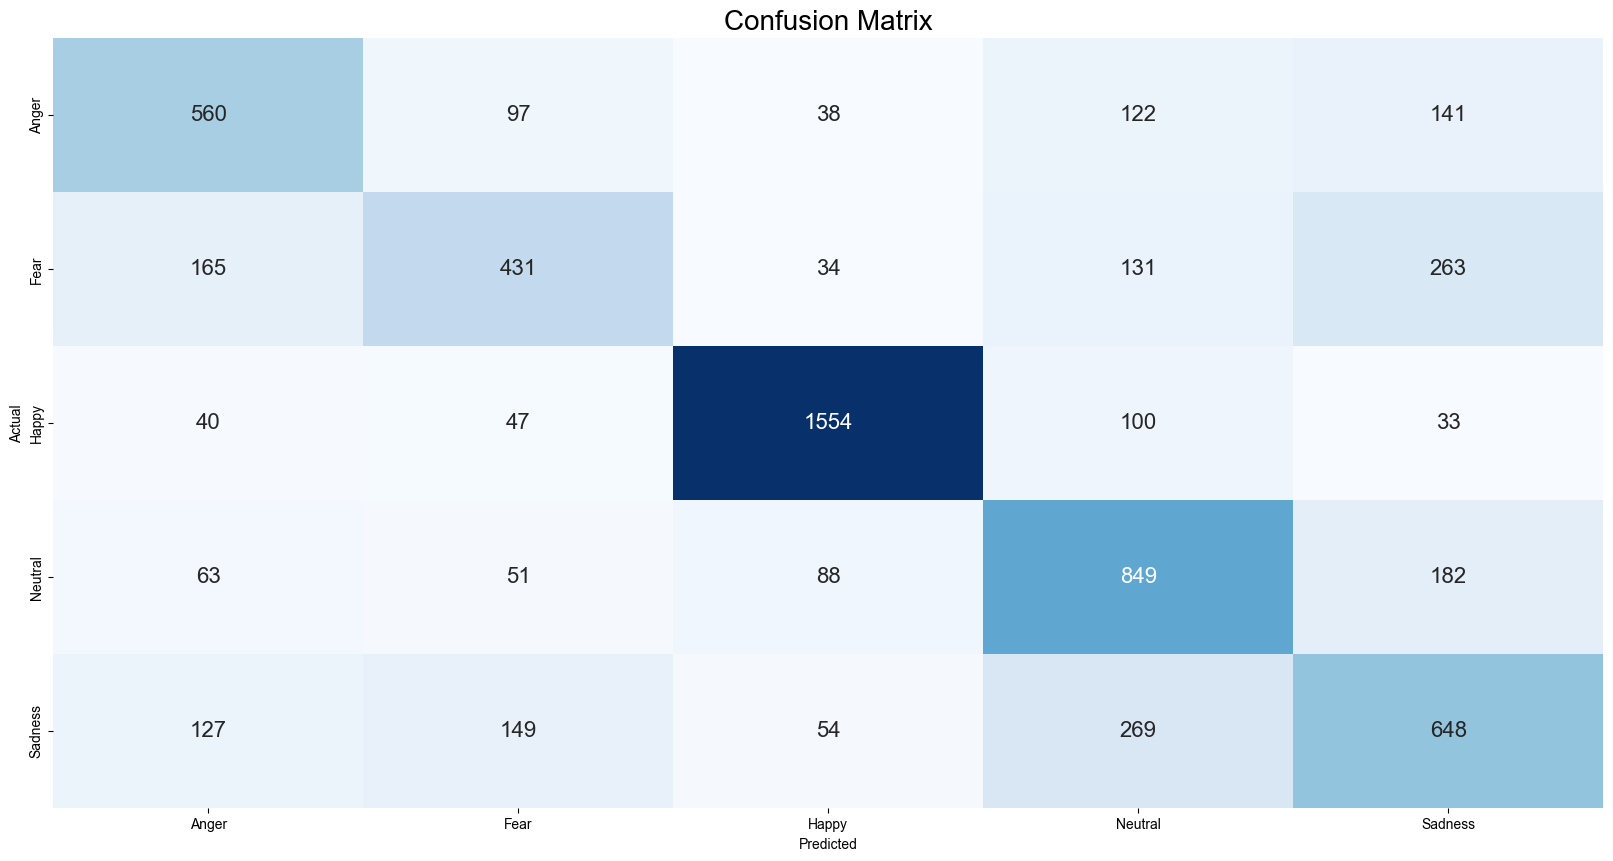

In [17]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [18]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.59      0.58      0.59       958
           1       0.56      0.42      0.48      1024
           2       0.88      0.88      0.88      1774
           3       0.58      0.69      0.63      1233
           4       0.51      0.52      0.52      1247

    accuracy                           0.65      6236
   macro avg       0.62      0.62      0.62      6236
weighted avg       0.65      0.65      0.65      6236



## Multiclass AUC Curve

ROC AUC score: 0.8908034176156902


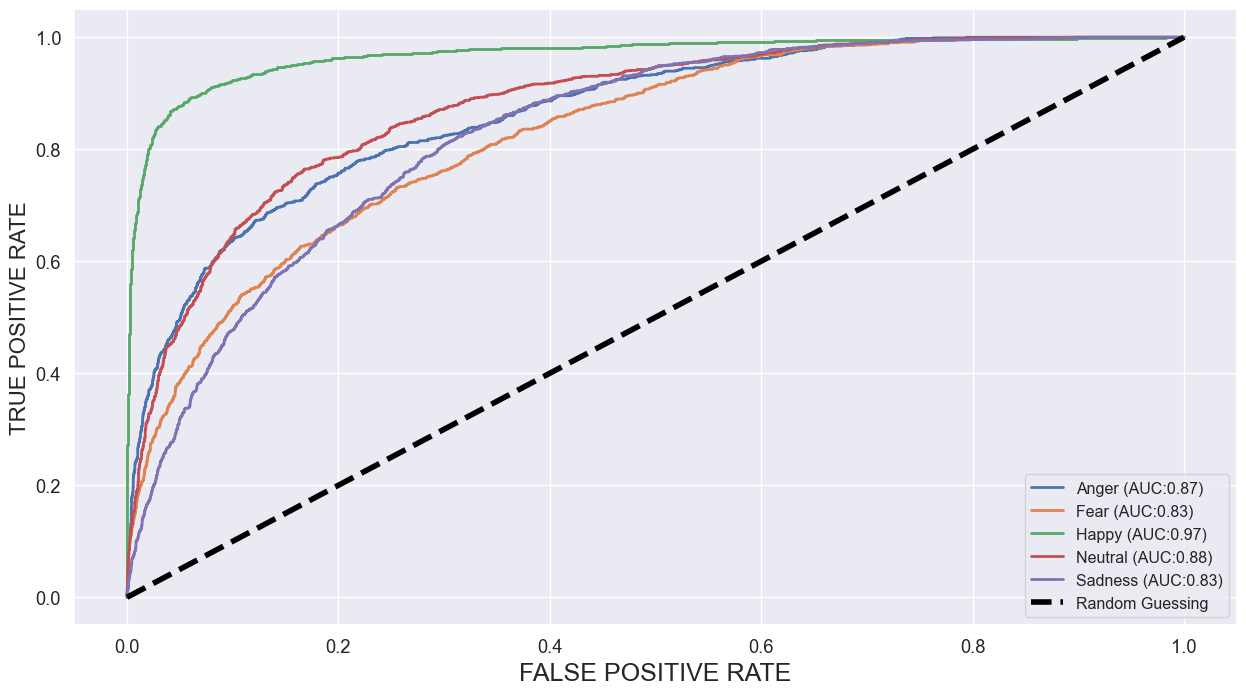

In [19]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [20]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8741797225796303


In [21]:
# Load the trained model
from keras.models import load_model

model = load_model("emotion_predictor.h5")

In [22]:
!pip install opencv-python
import cv2

# Function to preprocess the image (resize to 48x48)
def preprocess_image(image_path, img_height=48, img_width=48):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (img_width, img_height))  # Resize to 48x48
    img = img / 255.0  # Normalize pixel values (0-1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

1/1 [==============================] - 0s 30ms/step
Predicted Emotion: Anger (Confidence: 0.85)


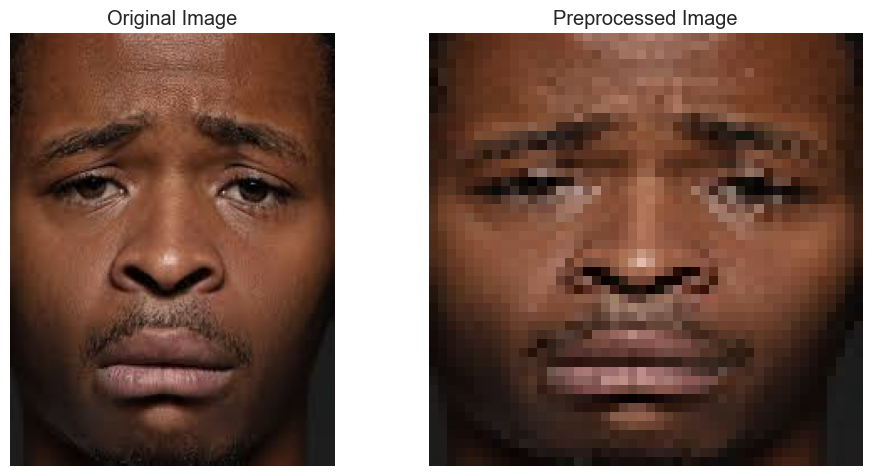

In [39]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load and preprocess the sample image
image_path = "5.jpg"  # Replace with your image path
processed_img = preprocess_image(image_path)

# Make a prediction
predictions = model.predict(processed_img)
predicted_class = np.argmax(predictions)  # Get class index
confidence = np.max(predictions)  # Get confidence score

# Display the result
print(f"Predicted Emotion: {CLASS_LABELS[predicted_class]} (Confidence: {confidence:.2f})")

# Load the original image for display
original_img = cv2.imread(image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Create a side-by-side display using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the preprocessed image (normalized and resized)
axes[1].imshow(processed_img[0])  # processed_img has an additional batch dimension
axes[1].set_title("Preprocessed Image")
axes[1].axis('off')

# Show both images
plt.tight_layout()
plt.show()
